# Estimate Roughness from LCDB v5

In [1]:
import rioxarray
import pathlib
import geopandas
import shapely
import geoapis.vector
import dotenv
import os
import numpy
import xarray

In [2]:
lcdb_id = 104400

In [3]:
crs = 2193
base_path = pathlib.Path(r"C:\Local\data\catchments\Waikanae\caches\roughness\land_cover")

In [4]:
x0=1767800; x1=1775500
y0=5469612; y1=5477770
bbox = geopandas.GeoDataFrame(geometry=[shapely.geometry.Polygon([[x0,y0],[x0,y1],[x1,y1],[x1,y0]])], crs=crs)

### Define Zo Lookup table
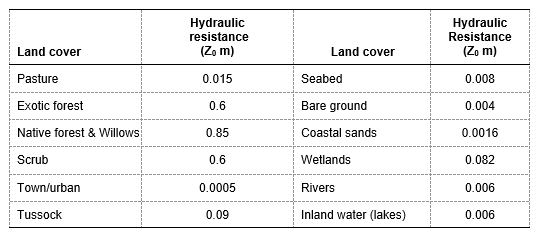

From Westport flood mapping study, NIWA Client Report:  CHC2003-064, July 2023, NIWA Project:   BDC03501. Maurice Duncan, Ude Shankar, Graeme Smart, Andrew Willsman


In [5]:
# Lookup table values derived from - https://apps.dtic.mil/sti/tr/pdf/ADA274550.pdf
# And also some set from values given from Graeme - will need to replace with something to cite
ZO_LOOKUP = {
    "Transport Infrastructure": 0.0005,
    'Exotic Forest': 0.6,
    'Built-up Area (settlement)': 0.0005,
    'Low Producing Grassland': 0.09,
    'River': 0.006,
    'Herbaceous Freshwater Vegetation': 0.082, 
    'Indigenous Forest': 0.85,
    'Broadleaved Indigenous Hardwoods': 0.85,
    'Lake or Pond': 0.006,  
    'Manuka and/or Kanuka': 0.6, 
    'Gorse and/or Broom': 0.6, 
    'High Producing Exotic Grassland': 0.09, 
    'Deciduous Hardwoods': 0.85, 
    'Sand or Gravel': 0.0016,  
    'Mixed Exotic Shrubland': 0.6, 
    'Surface Mine or Dump': 0.004,  
    'Orchard, Vineyard or Other Perennial Crop': 0.09, 
    'Forest - Harvested': 0.004, 
    'Gravel or Rock': 0.0016,  
    'Fernland': 0.6, 
    "Matagouri or Grey Scrub": 0.6, 
    "Urban Parkland/Open Space": 0.0005, 
}

### Load in land cover map

In [6]:
if not (base_path / "lcdb_v5.gpkg").exists():
    dotenv.load_dotenv()
    lris_key = os.environ.get("LRIS_API", None)
    fetcher = geoapis.vector.Lris(key=lris_key,
                                  bounding_polygon=bbox,
                                  verbose=True,
                                 )
    land_cover = fetcher.run(layer=lcdb_id)
    land_cover.to_file(base_path / "lcdb_v5.gpkg")
else:
    land_cover = geopandas.read_file(base_path / "lcdb_v5.gpkg")

### Drop unwanted years

In [7]:
# Clean data
year_to_keep = 2012
years_to_drop = [2001, 1996, 2008, 2018]
columns = ['EditAuthor', 'EditDate']
for year in years_to_drop:
    columns.extend([f"Name_{year}", f"Class_{year}", f"Wetland_{str(year)[-2:]}", f"Onshore_{str(year)[-2:]}"])
land_cover = land_cover.drop(columns=columns)

### Load in DEM

In [8]:
dem = rioxarray.rioxarray.open_rasterio(base_path / ".." / "geofabrics" / "geofabric_4m_with_waterways.nc",
            masked=True,
            parse_coordinates=True,
        ).squeeze("band", drop=True)
if "data_source" in dem.keys():
    dem["data_source"] = dem.data_source.astype(numpy.float32)
if "lidar_source" in dem.keys():
    dem["lidar_source"] = dem.data_source.astype(numpy.float32)
if "z" in dem.keys():
    dem["z"] = dem.z.astype(numpy.float32)

### Map zo

In [9]:
dem["zo"] = xarray.zeros_like(dem.z)
dem.zo.rio.write_crs(crs, inplace=True)
dem.zo.rio.write_nodata(numpy.nan, encoded=True, inplace=True)
for name in land_cover[f"Name_{year_to_keep}"].unique():
    print(f"name {name}, and value {ZO_LOOKUP[name]}")
    dem["zo"] = dem.zo.where(
        dem.zo.rio.clip(land_cover[land_cover[f"Name_{year_to_keep}"]==name].geometry, drop=False).isnull(),
        ZO_LOOKUP[name]
    )
dem["zo"] = dem.zo.where(dem.zo!=0, 0.004)

name Manuka and/or Kanuka, and value 0.6
name Exotic Forest, and value 0.6
name Built-up Area (settlement), and value 0.0005
name High Producing Exotic Grassland, and value 0.09
name Low Producing Grassland, and value 0.09
name River, and value 0.006
name Herbaceous Freshwater Vegetation, and value 0.082
name Indigenous Forest, and value 0.85
name Broadleaved Indigenous Hardwoods, and value 0.85
name Lake or Pond, and value 0.006
name Gorse and/or Broom, and value 0.6
name Urban Parkland/Open Space, and value 0.0005
name Deciduous Hardwoods, and value 0.85
name Sand or Gravel, and value 0.0016
name Forest - Harvested, and value 0.004
name Surface Mine or Dump, and value 0.004
name Transport Infrastructure, and value 0.0005
name Mixed Exotic Shrubland, and value 0.6
name Orchard, Vineyard or Other Perennial Crop, and value 0.09
name Gravel or Rock, and value 0.0016
name Fernland, and value 0.6
name Matagouri or Grey Scrub, and value 0.6


In [10]:
zo = dem.drop(["data_source", "lidar_source", "z"])
zo.to_netcdf(base_path / f"zo_table_niwa_westport_report_{year_to_keep}.nc")